In [1]:
import random

In [2]:
random_seed = 10
random.seed(random_seed)

In [3]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformer
%pip install gensim

ERROR: Could not find a version that satisfies the requirement sentence-transformer (from versions: none)
ERROR: No matching distribution found for sentence-transformer


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
#import openai
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df.head(5)

,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}


In [7]:
#stop words, lower case, and remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# preprocessing function
def clean_text(text):
    # convert non-string types to string for potential na vals
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    # Use regular expression to replace all punctuation with a space
    text = re.sub(f'[{re.escape("".join(punctuation))}]', ' ', text)
    tokens = text.split()
    # Removed the strip() call as regex handles punctuation removal
    # tokens = [word.strip("".join(punctuation)) for word in tokens]
    tokens = [word for word in tokens if word and word not in stop_words]
    return tokens

# Add cleaned tokens to the df
df["tokens"] = df["summary"].apply(clean_text)

# Define the list of words to filter out
words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges'}

# filter out words that we think are not helpful
df['flt_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])


df['flt_tokens'] = df['flt_tokens'].apply(lambda x: ' '.join(x))

# Embedding

In [8]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)

    if 'embedding' not in df.columns:
        df['embedding'] = None

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()



Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

## Model Creation

In [9]:
## bertopic.py ##

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)

embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()


###########Changes Here#################

# Initialize BERTopic model with a random_state for reproducibility
bertopic_model = BERTopic(random.seed(random_seed))

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

df_embeddings['topic'] = topics
df_embeddings['probs'] = probs

# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())


# Reduce outliers (optional)
# This requires the original documents, so we use df_embeddings['flt_tokens']
new_topics = bertopic_model.reduce_outliers(
  df_embeddings['flt_tokens'].tolist(), topics, strategy="distributions"
)
df_embeddings['new_topic'] = new_topics

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{-1: [('ran', 0.029779733308302116), ('gar', 0.026421929661685443), ('indonesia', 0.02190727727411514), ('jaya', 0.02157576932374123), ('forests', 0.02131795211097743), ('plantation', 0.020916457057396528), ('greenpeace', 0.0197580242550037), ('forest', 0.018213651337800733), ('land', 0.01806684854479149), ('deforestation', 0.017783693702591422)], 0: [('land', 0.058352143181591744), ('communities', 0.025146184554916275), ('local', 0.020565045497869666), ('new', 0.020093562138420906), ('hcv', 0.019962165910655773), ('complainants', 0.018810014649927258), ('principle', 0.01865200059844392), ('customary', 0.018378253857583404), ('lands', 0.01820924539866229), ('prior', 0.017905920574506164)], 1: [('earth', 0.11754970124038365), ('mighty', 0.11623648561336539), ('ha', 0.11379635544441632), ('rapid', 0.11017276356143683), ('response', 0.10104288958565578), ('concession', 0.09768099677586885), ('deforestation', 0.08977345378712016), ('indications', 0.0854710058

In [10]:
print(df_embeddings['new_topic'].value_counts())

new_topic
0    131
1     62
3     42
4     41
2     38
5     32
7     21
6     20
Name: count, dtype: int64


In [11]:
print(df_embeddings['new_topic'].isin([-1]).sum())

0


In [12]:
print(bertopic_model.get_topic_info())

   Topic  Count                                 Name  \
0     -1    102            -1_ran_gar_indonesia_jaya   
1      0     86         0_land_communities_local_new   
2      1     50              1_earth_mighty_ha_rapid   
3      2     36    2_workers_casual_daily_employment   
4      3     31            3_eof_mill_forest_illegal   
5      4     26     4_deforestation_gar_chain_linked   
6      5     21  5_clearance_forest_ecosystem_leuser   
7      6     18  6_labour_rights_transnational_tpols   
8      7     17                 7_ffb_cpo_park_bukit   

                                      Representation  \
0  [ran, gar, indonesia, jaya, forests, plantatio...   
1  [land, communities, local, new, hcv, complaina...   
2  [earth, mighty, ha, rapid, response, concessio...   
3  [workers, casual, daily, employment, union, bp...   
4  [eof, mill, forest, illegal, plantation, plant...   
5  [deforestation, gar, chain, linked, supply, ra...   
6  [clearance, forest, ecosystem, leuser, peat,

In [13]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic -1 Representation: ['ran', 'gar', 'indonesia', 'jaya', 'forests', 'plantation', 'greenpeace', 'forest', 'land', 'deforestation']
Topic 0 Representation: ['land', 'communities', 'local', 'new', 'hcv', 'complainants', 'principle', 'customary', 'lands', 'prior']
Topic 1 Representation: ['earth', 'mighty', 'ha', 'rapid', 'response', 'concession', 'deforestation', 'indications', 'total', 'hectares']
Topic 2 Representation: ['workers', 'casual', 'daily', 'employment', 'union', 'bpjs', 'working', 'termination', 'labour', 'work']
Topic 3 Representation: ['eof', 'mill', 'forest', 'illegal', 'plantation', 'plantations', 'grievance', 'investigations', 'riau', '2016']
Topic 4 Representation: ['deforestation', 'gar', 'chain', 'linked', 'supply', 'raya', 'jaya', 'mighty', 'earth', 'rapid']
Topic 5 Representation: ['clearance', 'forest', 'ecosystem', 'leuser', 'peat', 'biodiversity', 'potential', 'habitat', 'peatlands', 'ha']
Topic 6 Representation: ['labour', 'rights', 'transnational', 'tpols'

In [14]:
bertopic_model.visualize_hierarchy()

In [15]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 7/7 [00:00<00:00, 303.42it/s]


In [16]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)


In [17]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

# Visualizations

In [18]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [19]:
# Ensure df_embeddings and bertopic_model are available
if 'df_embeddings' not in locals() or 'bertopic_model' not in locals():
    print("Error: 'df_embeddings' or 'bertopic_model' not found. Please run the data loading, embedding, and BERTopic modeling cells first.")
else:
    # Create a list of dictionaries to hold the data for the new DataFrame
    data = []

    # Iterate through the rows of df_embeddings
    for index, row in df_embeddings.iterrows():
        doc_num = index  # Use the original index as document number
        dominant_topic = row['topic']
        topic_prob = row['probs']
        text = row['flt_tokens'] # Use flt_tokens as the 'Text'

        # Get the keywords for the dominant topic from the BERTopic model
        # bertopic_model.get_topic returns a list of (word, score) tuples
        if dominant_topic != -1: # Exclude the outlier topic
            keywords = ", ".join([word for word, score in bertopic_model.get_topic(dominant_topic)])
        else:
            keywords = "Outlier Topic" # Or handle outlier topic as needed

        data.append({
            'Document_Num': doc_num,
            'Dominant_Topic': dominant_topic,
            'Topic_%_Contrib': topic_prob,
            'Keywords': keywords,
            'Text': text
        })

    # Create the DataFrame
    dominant_topic_df = pd.DataFrame(data)

    # Display the first few rows
    display(dominant_topic_df.head(5))

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
0,0,2,0.677393,"workers, casual, daily, employment, union, bpj...",transferred different department purportedly p...
1,1,2,0.838164,"workers, casual, daily, employment, union, bpj...",unjustifiably dismissed workers deceiving resi...
2,2,0,0.950455,"land, communities, local, new, hcv, complainan...",1 owns operates plantations conflicted contest...
3,3,-1,0.000000,Outlier Topic,corporate social responsibility csr program co...
4,4,0,0.837836,"land, communities, local, new, hcv, complainan...",breached obligations ignoring high conservatio...


In [20]:
display(dominant_topic_df.head(5))

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
0,0,2,0.677393,"workers, casual, daily, employment, union, bpj...",transferred different department purportedly p...
1,1,2,0.838164,"workers, casual, daily, employment, union, bpj...",unjustifiably dismissed workers deceiving resi...
2,2,0,0.950455,"land, communities, local, new, hcv, complainan...",1 owns operates plantations conflicted contest...
3,3,-1,0.000000,Outlier Topic,corporate social responsibility csr program co...
4,4,0,0.837836,"land, communities, local, new, hcv, complainan...",breached obligations ignoring high conservatio...


## Data Exploration

In [21]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == -1]

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
3,3,-1,0.0,Outlier Topic,corporate social responsibility csr program co...
12,12,-1,0.0,Outlier Topic,failure carry corporate social responsibility ...
13,13,-1,0.0,Outlier Topic,allegation pertaining plasma allocation ratio ...
14,14,-1,0.0,Outlier Topic,yet fulfill commitment allocate plasma land
16,16,-1,0.0,Outlier Topic,representative crude producer allegations rega...
...,...,...,...,...,...
374,391,-1,0.0,Outlier Topic,public case released september 2018
375,393,-1,0.0,Outlier Topic,public case released september 2018
378,404,-1,0.0,Outlier Topic,forest clearance involvement land dispute indo...
382,421,-1,0.0,Outlier Topic,rights violations land conflict sandabi indah ...


## Wordcloud

In [22]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds', n_topics=8)

Output hidden; open in https://colab.research.google.com to view.

## Dominant Topic Frequency

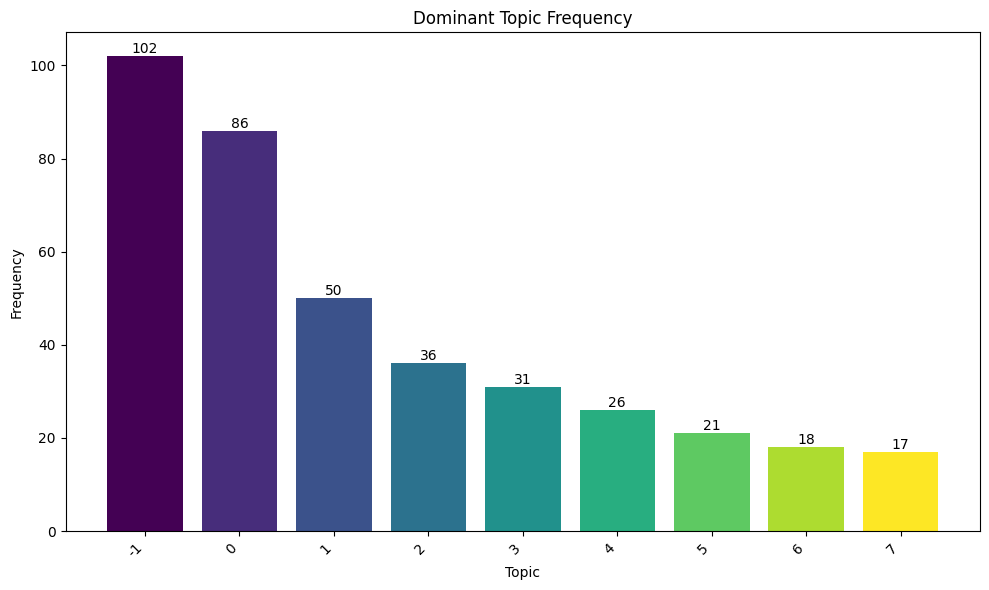

In [23]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure dominant_topic_df is available
if  'dominant_topic_df' not in locals():
    print("Error:  dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Calculate topic share (frequency) from dominant_topic_df
    df_topic_share = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()

## Overall Dominant Topic % Share

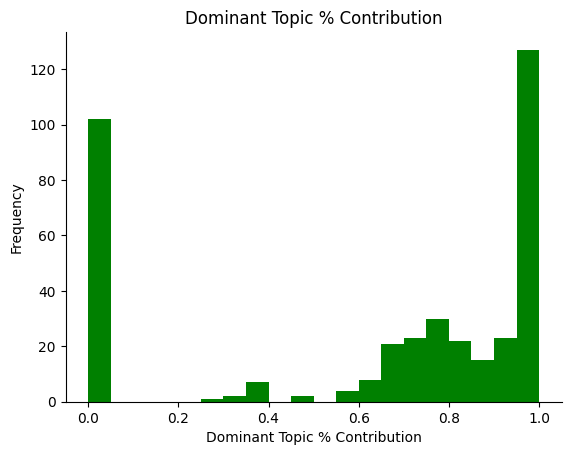

In [24]:
# Ensure dominant_topic_df is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_df
    dominant_topic_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color="green")
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot

# Topic Coherence Score

In [26]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

# Get topics from the fitted model
all_topics = bertopic_model.get_topics()

# Extract topic words, excluding the outlier topic (-1)
topic_words = [[word for word, _ in all_topics[i]] for i in all_topics if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)

Topic Coherence: 0.6955261276468789


# Topic Diversity

In [28]:
# Get topics from the fitted model, excluding the outlier topic (-1)
topic_words = [bertopic_model.get_topic(i) for i in bertopic_model.get_topics() if i != -1]

top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

Topic Diversity: 0.9


# Silhouette Score

In [29]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

Silhouette Score: 0.07221681


# Davies Bouldin Index

In [30]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

Davies-Bouldin Index: 2.793693024530979


# Visualizations (Forced Classification)

In [ ]:
#replace old topic labels with new topics we got from reduced outlier
df_forced_embeddings = df_embeddings
df_forced_embeddings['topic'] = new_topics

## Create Dataframe with Results

In [ ]:
### now using the new topics

# Ensure df_forced_embeddings and bertopic_model are available
if 'df_forced_embeddings' not in locals() or 'bertopic_model' not in locals():
    print("Error: 'df_forced_embeddings' or 'bertopic_model' not found. Please run the data loading, embedding, and BERTopic modeling cells first.")
else:
    # Create a list of dictionaries to hold the data for the new DataFrame
    data = []

    # Iterate through the rows of df_forced_embeddings
    for index, row in df_forced_embeddings.iterrows():
        doc_num = index  # Use the original index as document number
        dominant_topic = row['new_topic']
        topic_prob = row['probs']
        text = row['flt_tokens'] # Use flt_tokens as the 'Text'

        # Get the keywords for the dominant topic from the BERTopic model
        # bertopic_model.get_topic returns a list of (word, score) tuples
        if dominant_topic != -1: # Exclude the outlier topic
            keywords = ", ".join([word for word, score in bertopic_model.get_topic(dominant_topic)])
        else:
            keywords = "Outlier Topic" # Or handle outlier topic as needed

        data.append({
            'Document_Num': doc_num,
            'Dominant_Topic': dominant_topic,
            'Topic_%_Contrib': topic_prob,
            'Keywords': keywords,
            'Text': text
        })

    # Create the DataFrame
    dominant_topic_forced_df = pd.DataFrame(data)

    # Display the first few rows
    display(dominant_topic_forced_df.head(5))

## Data Exploration

In [ ]:
dominant_topic_forced_df[dominant_topic_df['Dominant_Topic'] == 0]

In [ ]:
from collections import Counter

for topic in sorted(df_forced_embeddings['topic'].unique()):
    docs_in_topic = df_forced_embeddings.loc[df_forced_embeddings['topic'] == topic, 'flt_tokens']
    # Join all docs' tokens and count frequencies
    all_tokens = ' '.join(docs_in_topic).split()
    common_words = Counter(all_tokens).most_common(10)
    print(f"Topic {topic} top words: {[word for word, count in common_words]}")

## Wordcloud

In [ ]:
#again for new topics

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_forced_df[dominant_topic_forced_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_forced_df, title='Topic Classification Wordclouds', n_topics=8)

## Dominant Topic Frequency

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure dominant_topic_forced_df is available
if 'dominant_topic_forced_df' not in locals():
    print("Error: 'dominant_topic_forced_df' not found. Please run the cell that creates dominant_topic_forced_df first.")
else:
    # Calculate topic share (frequency) from dominant_topic_forced_df
    df_topic_share = dominant_topic_forced_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()

## Overall Dominant Topic % Share

In [ ]:
dominant_topic_forced_df[dominant_topic_forced_df['Topic_%_Contrib'] == 0.0]

In [ ]:
# Ensure dominant_topic_forced_df is available
if 'dominant_topic_forced_df' not in locals():
    print("Error: 'dominant_topic_forced_df' not found. Please run the cell that creates dominant_topic_forced_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_forced_df
    dominant_topic_forced_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color='green')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot